# Case 14 Powerflow Solver Test

## Run simulation

### Import Libraries

In [32]:
import sys
sys.path.insert(0,'/home/mmo-gog/dpsim/build/')
sys.path.insert(0,'/home/mmo-gog/dpsim/python/src/dpsim')

import matpower
import dpsimpy

from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt

%matplotlib widget

### Simulation parameters

In [33]:
# simulation files
path_static_file = '/home/mmo-gog/dpsim/examples/Notebooks/MatDyn/IEEE14/ieee14.mat'
path_dynamic_file = '/home/mmo-gog/dpsim/examples/Notebooks/MatDyn/IEEE14/ieee14_dyn.mat'

### 1. Powerflow for initialization

In [34]:
sim_name_pf = 'IEEE14_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader = matpower.Reader(mpc_file_path=path_static_file, mpc_name='ieee14',
                             mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='ieee14_dyn')
mpc_reader.load_mpc(domain=matpower.Domain.PF)
system_pf = mpc_reader.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

[17:08:02.003451 IEEE14_PF info] Initialize simulation: IEEE14_PF
[17:08:02.003981 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N4
[17:08:02.003987 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N5
[17:08:02.003992 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N7
[17:08:02.003997 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N9
[17:08:02.003999 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N9
[17:08:02.004002 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N10
[17:08:02.004004 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N11
[17:08:02.004007 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N12
[17:08:02.004010 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N13
[17:08:02.004013 IEEE14_PF_PF_Solver warning] Unable to get base voltage at N14
[17:08:02.004347 IEEE14_PF info] Scheduling tasks.
[17:08:02.004529 IEEE14_PF info] Scheduling done.
[17:08:02.004531 IEEE14_PF info] Openi

### Read pf results

In [35]:
dpsim_result_file = 'logs/' + sim_name_pf + '/' + sim_name_pf + '.csv'
ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

column number: 28
results length: 2
real column names: []
complex column names: ['N1.S', 'N1.V', 'N10.S', 'N10.V', 'N11.S', 'N11.V', 'N12.S', 'N12.V', 'N13.S', 'N13.V', 'N14.S', 'N14.V', 'N2.S', 'N2.V', 'N3.S', 'N3.V', 'N4.S', 'N4.V', 'N5.S', 'N5.V', 'N6.S', 'N6.V', 'N7.S', 'N7.V', 'N8.S', 'N8.V', 'N9.S', 'N9.V']


#### DPsim results

In [36]:
dpsim_results = pd.DataFrame(columns=['Bus', 'V_mag(pu)', 'V_angle(deg)', 'P(pu)', 'Q(pu)'])
base_power = 100 #mw
for i in range(len(system_pf.nodes)):
    node_name = system_pf.nodes[i].name() #ex. N5
    node_number = node_name.replace('N', '')
    node_baseV = mpc_reader.mpc_bus_data.loc[mpc_reader.mpc_bus_data['bus_i'] == int(node_number), 'baseKV'].iloc[0] * 1e3
    w_mw = 1e-6
    dpsim_results.loc[i] = ([node_name] + [round(np.absolute(ts_dpsim_pf[node_name + '.V'].values[-1]) / node_baseV, 4)]
        + [round(np.angle(ts_dpsim_pf[node_name + '.V'].values[-1]*180/np.pi), 4)] 
        + [round(w_mw * np.real(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 4)] 
        + [round(w_mw * np.imag(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 5)])

dpsim_results

,Bus,V_mag(pu),V_angle(deg),P(pu),Q(pu)
0,N1,1.0600,0.0000,2.3239,-0.16889
1,N2,1.0450,-0.0869,0.1830,0.29696
2,N3,1.0100,-0.2220,-0.9420,0.04394
3,N4,1.0186,-0.1802,-0.4780,0.03900
4,N5,1.0203,-0.1533,-0.0760,-0.01600
5,N6,1.0700,-0.2482,-0.1120,0.04740
6,N7,1.0620,-0.2333,0.0000,0.00000
7,N8,1.0900,-0.2333,-0.0000,0.17357
8,N9,1.0563,-0.2609,-0.2950,0.04601
9,N10,1.0513,-0.2636,-0.0900,-0.05800


### Validate Results against PSAT

In [37]:
### PSAT Results
voltage_mag = np.array([1.06, 1.045, 1.01, 1.0186, 1.0203, 1.07, 1.062, 1.09, 1.0564, 1.0513, 1.0571, 1.0552, 1.0504, 1.0358])
voltage_angle = np.array([0, -0.08693, -0.22197, -0.18019, -0.15328, -0.24823, -0.23332, -0.23332, -0.26087, -0.26362, -0.25823, -0.26315, -0.26457, -0.27993])
p_loads = np.array([0, 0.217, 0.942, 0.478, 0.076, 0.112, 0, 0, 0.295, 0.09, 0.035, 0.061, 0.135, 0.149])
q_loads = np.array([0,  0.127, 0.19, -0.039, 0.016, 0.075, 0, 0, -0.04601, 0.058, 0.018, 0.016, 0.058, 0.05])
p_gen = np.array([2.3239, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
q_gen = np.array([-0.16889, 0.42396, 0.23394, 0, 0, 0.1224, 0, 0.17357, 0, 0, 0, 0, 0, 0])
busses = ["N1", "N2", "N3", "N4", "N5", "N6", "N7", "N8", "N9", "N10", "N11", "N12", "N13", "N14"]
d = {"Bus": busses, "V_mag(pu)": voltage_mag, "V_angle(deg)": voltage_angle, "P(pu)": -p_loads+p_gen, "Q(pu)": -q_loads+q_gen}
psat_results = pd.DataFrame(d)

psat_results

,Bus,V_mag(pu),V_angle(deg),P(pu),Q(pu)
0,N1,1.0600,0.00000,2.3239,-0.16889
1,N2,1.0450,-0.08693,0.1830,0.29696
2,N3,1.0100,-0.22197,-0.9420,0.04394
3,N4,1.0186,-0.18019,-0.4780,0.03900
4,N5,1.0203,-0.15328,-0.0760,-0.01600
5,N6,1.0700,-0.24823,-0.1120,0.04740
6,N7,1.0620,-0.23332,0.0000,0.00000
7,N8,1.0900,-0.23332,0.0000,0.17357
8,N9,1.0564,-0.26087,-0.2950,0.04601
9,N10,1.0513,-0.26362,-0.0900,-0.05800


### Difference

In [38]:
difference_vmag = psat_results['V_mag(pu)'] - dpsim_results['V_mag(pu)']
difference_vmag[0:4] = difference_vmag[0:4] * 69000
difference_vmag[7] = difference_vmag[7] * 18000
difference_vmag[5:6] = difference_vmag[5:6] * 13800
difference_vmag[8:-1] = difference_vmag[8:-1] * 13800
difference_vangle = psat_results['V_angle(deg)'] - dpsim_results['V_angle(deg)']

#base power = 100MW
difference_p = (psat_results['P(pu)'] - dpsim_results['P(pu)'])*100*1e6
difference_q = (psat_results['Q(pu)'] - dpsim_results['Q(pu)'])*100*1e6
difference = {"Bus": busses, "V_mag [V]": difference_vmag, "V_angle [deg]": difference_vangle, "P [W]": difference_p, "Q [VAr]": difference_q}
difference = pd.DataFrame(difference)

difference

,Bus,V_mag [V],V_angle [deg],P [W],Q [VAr]
0,N1,0.00,0.00000,0.000000e+00,0.000000e+00
1,N2,0.00,-0.00003,2.775558e-09,0.000000e+00
2,N3,0.00,0.00003,0.000000e+00,6.938894e-10
3,N4,0.00,0.00001,0.000000e+00,0.000000e+00
4,N5,0.00,0.00002,0.000000e+00,0.000000e+00
5,N6,0.00,-0.00003,0.000000e+00,0.000000e+00
6,N7,0.00,-0.00002,0.000000e+00,0.000000e+00
7,N8,0.00,-0.00002,0.000000e+00,0.000000e+00
8,N9,1.38,0.00003,0.000000e+00,0.000000e+00
9,N10,0.00,-0.00002,0.000000e+00,0.000000e+00


### Assertion

In [39]:
print(np.max(np.absolute(difference_p)))
assert(np.all(np.absolute(difference_p)<3e-9))    #Watt
print(np.max(np.absolute(difference_q)))
assert(np.all(np.absolute(difference_q)<1000.1))    #Watt

print(np.max(difference_vmag))
assert(np.all(difference_vmag)<1.38)

print(np.max(difference_vangle))
assert(np.all(difference_vangle)<1e-9)

2.7755575615628914e-09
6.938893903907228e-10
1.379999999999848
4.999999999999449e-05


### 2. Dynamic simulation with fault at Node 14

#### SP - Dynamic Simulation

In [40]:
sim_name_dyn_sp = 'SP_IEEE14_Dyn_InitPF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_sp)

# read and create dpsim topology
mpc_reader = matpower.Reader(mpc_file_path=path_static_file, mpc_name='ieee14',
                             mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='ieee14_dyn')
mpc_reader.create_dpsim_objects(domain=matpower.Domain.SP, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)

### Extend topology with switch between node N15 and groud
sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.1 * (13.8*13.8/100.0)
sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.sp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N14"]])

# create dpsim topology
system_dyn = mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf)

# log results
logger = dpsimpy.Logger(sim_name_dyn_sp)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
     
# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_sp, dpsimpy.LogLevel.info)
sim.set_system(system_dyn)
sim.set_time_step(1e-3)
sim.set_final_time(10)
sim.set_domain(dpsimpy.Domain.SP)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add event
sw_event_1 = dpsimpy.event.SwitchEvent(0.2, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.3, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.run()

2.000000e-01: Handle event time
3.000000e-01: Handle event time


[17:08:02.165212 SP_IEEE14_Dyn_InitPF info] Initialize simulation: SP_IEEE14_Dyn_InitPF
[17:08:02.165318 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[17:08:02.168314 SP_IEEE14_Dyn_InitPF_Solver warning] Linear solver configuration is not used!
[17:08:02.171753 SP_IEEE14_Dyn_InitPF info] Scheduling tasks.
[17:08:02.172059 SP_IEEE14_Dyn_InitPF info] Scheduling done.
[17:08:02.172061 SP_IEEE14_Dyn_InitPF info] Opening interfaces.
[17:08:02.172062 SP_IEEE14_Dyn_InitPF info] Start synchronization with remotes on interfaces
[17:08:02.172064 SP_IEEE14_Dyn_InitPF info] Synchronized simulation start with remotes
[17:08:02.172065 SP_IEEE14_Dyn_InitPF info] Start simulation: SP_IEEE14_Dyn_InitPF
[17:08:02.172067 SP_IEEE14_Dyn_InitPF info] Time step: 1.000000e-03
[17:08:02.172069 SP_IEEE14_Dyn_InitPF info] Final time: 1.000000e+01
[17:08:02.602346 SP_IEEE14_Dyn_InitPF info] Simulation calculation time: 0.430227
[17:08:02.616615 SP_IEEE14_Dyn_InitPF info] Simulation finish

#### DP - Dynamic Simulation

In [41]:
sim_name_dyn_dp = 'DP_IEEE14_Dyn_InitPF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_dp)

# read and create dpsim topology
mpc_reader = matpower.Reader(mpc_file_path=path_static_file, mpc_name='ieee14',
                             mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='ieee14_dyn')
mpc_reader.create_dpsim_objects(domain=matpower.Domain.DP, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)

### Extend topology with switch between node N15 and groud
sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.1 * (13.8*13.8/100.0)
sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.sp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N14"]])

# create dpsim topology
mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf)

# log results
logger = dpsimpy.Logger(sim_name_dyn_dp)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
     
# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_dp, dpsimpy.LogLevel.info)
sim.set_system(system_dyn)
sim.set_time_step(1e-3)
sim.set_final_time(10)
sim.set_domain(dpsimpy.Domain.SP)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add event
sw_event_1 = dpsimpy.event.SwitchEvent(0.2, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.3, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.run()

2.000000e-01

[17:08:02.667920 DP_IEEE14_Dyn_InitPF info] Initialize simulation: DP_IEEE14_Dyn_InitPF
[17:08:02.668036 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[17:08:02.671991 DP_IEEE14_Dyn_InitPF_Solver warning] Linear solver configuration is not used!
[17:08:02.675469 DP_IEEE14_Dyn_InitPF info] Scheduling tasks.
[17:08:02.675901 DP_IEEE14_Dyn_InitPF info] Scheduling done.
[17:08:02.675904 DP_IEEE14_Dyn_InitPF info] Opening interfaces.
[17:08:02.675905 DP_IEEE14_Dyn_InitPF info] Start synchronization with remotes on interfaces
[17:08:02.675906 DP_IEEE14_Dyn_InitPF info] Synchronized simulation start with remotes
[17:08:02.675907 DP_IEEE14_Dyn_InitPF info] Start simulation: DP_IEEE14_Dyn_InitPF
[17:08:02.675909 DP_IEEE14_Dyn_InitPF info] Time step: 1.000000e-03
[17:08:02.675911 DP_IEEE14_Dyn_InitPF info] Final time: 1.000000e+01
[17:08:03.187540 DP_IEEE14_Dyn_InitPF info] Simulation calculation time: 0.511584
[17:08:03.200976 DP_IEEE14_Dyn_InitPF info] Simulation finish

: Handle event time
3.000000e-01: Handle event time


#### EMT - Dynamic Simulation

In [42]:
sim_name_dyn_emt = 'EMT_IEEE14_Dyn_InitPF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_emt)

# read and create dpsim topology
mpc_reader = matpower.Reader(mpc_file_path=path_static_file, mpc_name='ieee14',
                             mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='ieee14_dyn')
mpc_reader.create_dpsim_objects(domain=matpower.Domain.EMT, frequency=60, log_level=dpsimpy.LogLevel.info, 
                                 with_avr=False, with_tg=False, with_pss=False)

### Extend topology with switch between node N15 and groud
sw = dpsimpy.emt.ph3.SeriesSwitch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.1 * (13.8*13.8/100.0)
sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.emt.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N14"]])

# create dpsim topology
mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf, dpsimpy.Domain.EMT)

# log results
logger = dpsimpy.Logger(sim_name_dyn_emt)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
     
# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_emt, dpsimpy.LogLevel.debug)
sim.set_system(system_dyn)
sim.set_time_step(1e-4)
sim.set_final_time(10)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add events
sw_event_1 = dpsimpy.event.SwitchEvent(0.2, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.3, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.set_time_step(1e-4)
sim.run()

2.000000e-01: Handle event time


[17:08:03.274548 EMT_IEEE14_Dyn_InitPF info] Initialize simulation: EMT_IEEE14_Dyn_InitPF


3.000000e-01: Handle event time


[17:08:03.274729 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[17:08:03.282245 EMT_IEEE14_Dyn_InitPF_Solver warning] Linear solver configuration is not used!
[17:08:03.289752 EMT_IEEE14_Dyn_InitPF info] Scheduling tasks.
[17:08:03.290170 EMT_IEEE14_Dyn_InitPF info] Scheduling done.
[17:08:03.290172 EMT_IEEE14_Dyn_InitPF info] Opening interfaces.
[17:08:03.290174 EMT_IEEE14_Dyn_InitPF info] Start synchronization with remotes on interfaces
[17:08:03.290175 EMT_IEEE14_Dyn_InitPF info] Synchronized simulation start with remotes
[17:08:03.290176 EMT_IEEE14_Dyn_InitPF info] Start simulation: EMT_IEEE14_Dyn_InitPF
[17:08:03.290178 EMT_IEEE14_Dyn_InitPF info] Time step: 1.000000e-04
[17:08:03.290180 EMT_IEEE14_Dyn_InitPF info] Final time: 1.000000e+01
[17:08:12.218800 EMT_IEEE14_Dyn_InitPF info] Simulation calculation time: 8.928570
[17:08:12.282451 EMT_IEEE14_Dyn_InitPF info] Simulation finished.


#### Read results

In [43]:
from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

dpsim_result_file = 'logs/' + sim_name_dyn_sp + '/' + sim_name_dyn_sp + '.csv'
ts_dpsim_sp = read_timeseries_csv(dpsim_result_file)
phasors = ts.phasors(ts_dpsim_sp)

dpsim_result_file = 'logs/' + sim_name_dyn_dp + '/' + sim_name_dyn_dp + '.csv'
ts_dpsim_dp = read_timeseries_csv(dpsim_result_file)

dpsim_result_file = 'logs/' + sim_name_dyn_emt + '/' + sim_name_dyn_emt + '.csv'
ts_dpsim_emt = read_timeseries_csv(dpsim_result_file)

column number: 15
results length: 10001
real column names: []
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N12.V', 'N13.V', 'N14.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V']
column number: 15
results length: 10001
real column names: []
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N12.V', 'N13.V', 'N14.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V']


column number: 43
results length: 100001
real column names: ['N1.V_0', 'N1.V_1', 'N1.V_2', 'N10.V_0', 'N10.V_1', 'N10.V_2', 'N11.V_0', 'N11.V_1', 'N11.V_2', 'N12.V_0', 'N12.V_1', 'N12.V_2', 'N13.V_0', 'N13.V_1', 'N13.V_2', 'N14.V_0', 'N14.V_1', 'N14.V_2', 'N2.V_0', 'N2.V_1', 'N2.V_2', 'N3.V_0', 'N3.V_1', 'N3.V_2', 'N4.V_0', 'N4.V_1', 'N4.V_2', 'N5.V_0', 'N5.V_1', 'N5.V_2', 'N6.V_0', 'N6.V_1', 'N6.V_2', 'N7.V_0', 'N7.V_1', 'N7.V_2', 'N8.V_0', 'N8.V_1', 'N8.V_2', 'N9.V_0', 'N9.V_1', 'N9.V_2', 'gnd.V']
complex column names: []


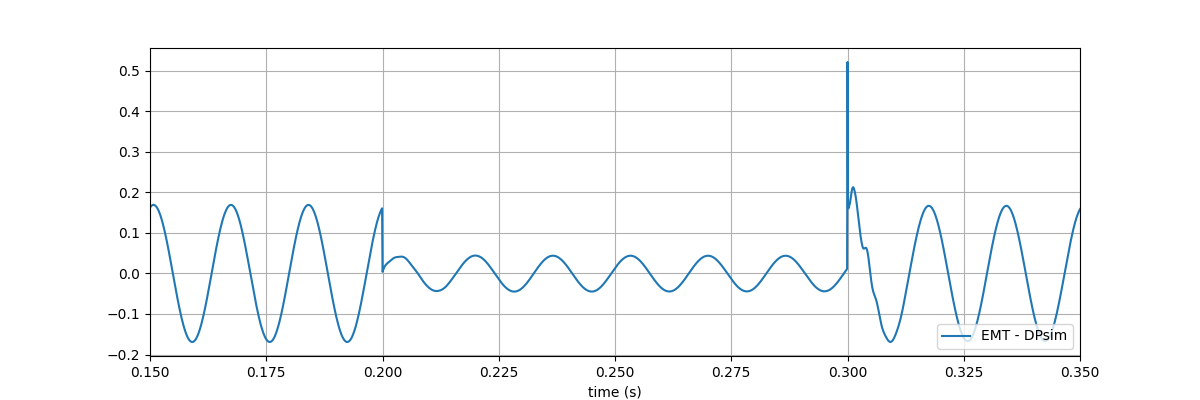

In [44]:
timestep_common = 1e-4
t_begin = 0.0
t_end = 3
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

varname_dpsim = 'N14.V_0'
nominal_voltage = 69000

#convert dpsim voltage to magnitude value and per-unit for comparison with psat
dpsim_dp_values = (ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]/nominal_voltage).real
    
plt.figure(figsize=(width, height))
plt.plot(time, dpsim_dp_values, label='EMT - DPsim')

plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.grid()
#plt.ylim([0.99, 1.06])
plt.xlim([0.15, 0.35])
plt.show()

#### Plot results

##### HV side

In [45]:
pt.plot_timeseries(1, phasors['N1.V']['abs'])
pt.plot_timeseries(1, phasors['N2.V']['abs'])
pt.plot_timeseries(1, phasors['N3.V']['abs'])
pt.plot_timeseries(1, phasors['N4.V']['abs'])
pt.plot_timeseries(1, phasors['N5.V']['abs'])

#### LV side

In [46]:
pt.plot_timeseries(1, phasors['N6.V']['abs'])
pt.plot_timeseries(1, phasors['N7.V']['abs'])
pt.plot_timeseries(1, phasors['N8.V']['abs'])
pt.plot_timeseries(1, phasors['N9.V']['abs'])
pt.plot_timeseries(1, phasors['N10.V']['abs'])
pt.plot_timeseries(1, phasors['N11.V']['abs'])
pt.plot_timeseries(1, phasors['N12.V']['abs'])
pt.plot_timeseries(1, phasors['N13.V']['abs'])
pt.plot_timeseries(1, phasors['N14.V']['abs'])

#### Validation against PSAT

#### Load PSAT results

In [47]:
#if not os.path.exists('reference-results'):
#    os.mkdir('reference-results')

#url = 'https://raw.githubusercontent.com/dpsim-simulator/reference-results/master/PSAT/SMIB-Fault/#PSAT_3OrderSyGen_SMIB_Fault_100mS_TS_1mS.out.txt'
#local_file_3Order = 'reference-results/PSAT_3OrderSyGen_SMIB_Fault_100mS_TS_1mS.out'
local_file = 'IEEE14/PSAT_IEEE14_Fault_N14_100uS_without_Controls_SG_4Order.txt'

#urllib.request.urlretrieve(url, local_file_3Order) 
ts_psat = read_timeseries_dpsim(local_file)

column number: 14
results length: 100004
real column names: ['V_Bus01', 'V_Bus02', 'V_Bus03', 'V_Bus04', 'V_Bus05', 'V_Bus06', 'V_Bus07', 'V_Bus08', 'V_Bus09', 'V_Bus10', 'V_Bus11', 'V_Bus12', 'V_Bus13', 'V_Bus14']
complex column names: []


### Plot results

In [48]:
timestep_common = 1e-3
t_begin = 0.0
t_end = 3
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

def plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, ylabels, timestep_common=0.001):
   
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    dpsim_dp_values = (ts_dpsim_dp[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]/nominal_voltage).real
    dpsim_sp_values_abs_pu = ts_dpsim_sp[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage
    dpsim_dp_values_abs_pu = ts_dpsim_dp[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage
    psat_values = ts_psat[varname_psat].interpolate(timestep_common).values[begin_idx:end_idx]
    
    plt.figure(figsize=(width, height))
    plt.plot(time, dpsim_dp_values_abs_pu, label='DP - DPsim')
    plt.plot(time, dpsim_sp_values_abs_pu, label='SP - DPsim')
    plt.plot(time, psat_values, '--', label='PSAT')

    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.grid()
    #plt.ylim([0.99, 1.06])
    #plt.xlim([8, 10])
    plt.show()
    
    plt.figure(figsize=(width, height))
    plt.plot(time, dpsim_dp_values_abs_pu, label='DP - DPsim')
    plt.plot(time, dpsim_sp_values_abs_pu, label='SP - DPsim')
    #plt.plot(time, dpsim_dp_values, '--', label='DP')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.grid()
    plt.xlim([0.15, 0.4])
    plt.show()
      
    #calculate RMSE
    rmse = np.sqrt(((dpsim_sp_values_abs_pu - psat_values) ** 2).mean())
    print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/1.0*100, 1.0))

#### HV side

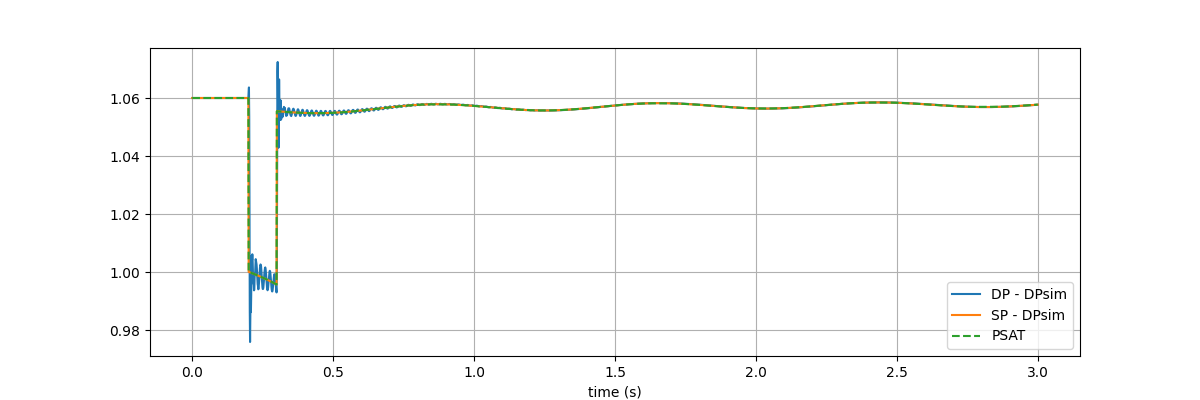

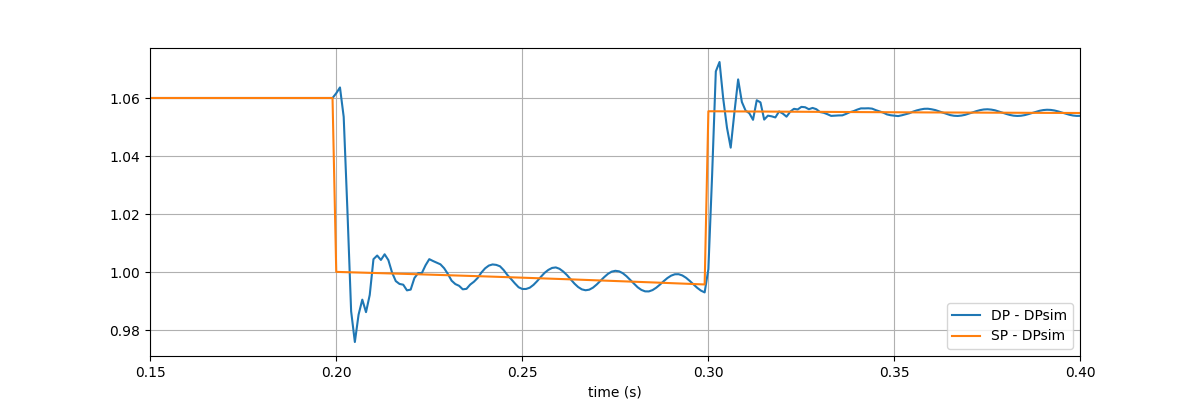

RMSE N1.V  = 0.000017 (pu), which is 0.002% of the nominal value = 1.000 (pu) 


In [49]:
varname_dpsim = 'N1.V'
varname_psat = 'V_Bus01'
nominal_voltage = 69000
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N1", timestep_common=0.001)

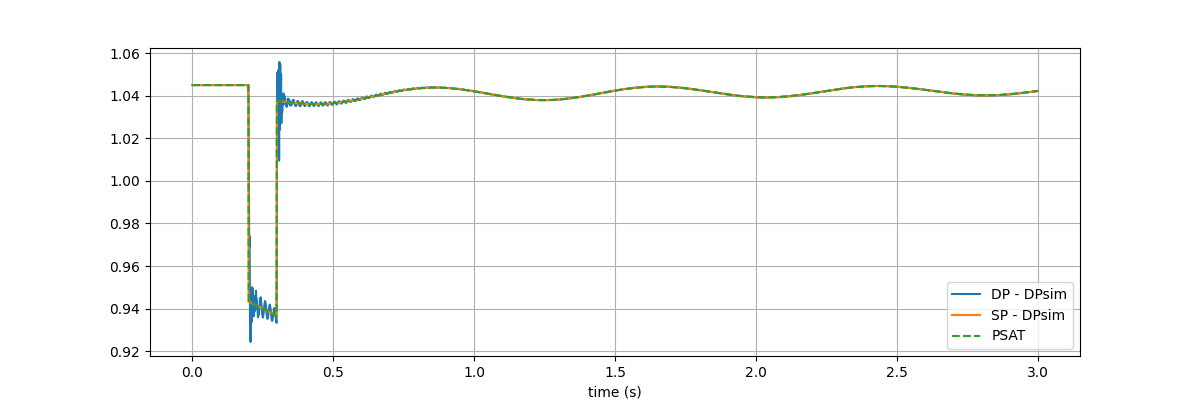

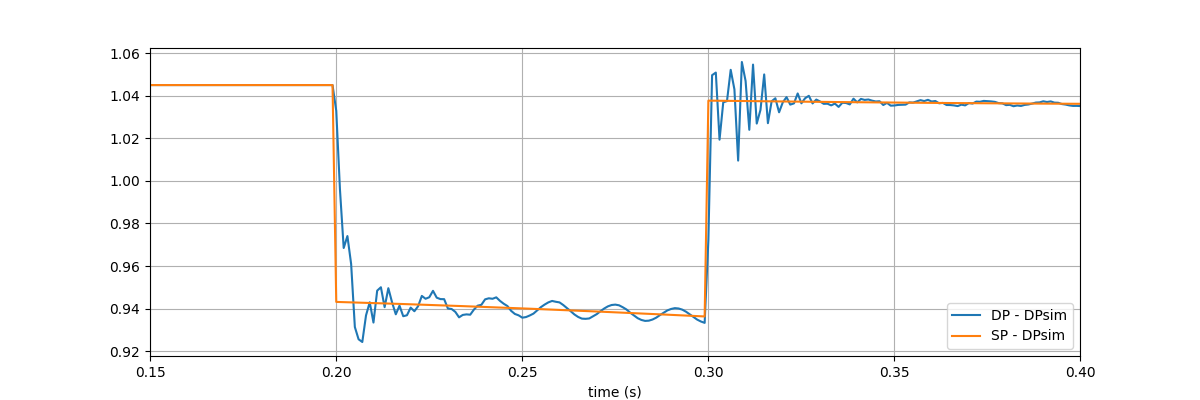

RMSE N2.V  = 0.000048 (pu), which is 0.005% of the nominal value = 1.000 (pu) 


In [50]:
varname_dpsim = 'N2.V'
varname_psat = 'V_Bus02'
nominal_voltage = 69000
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N2", timestep_common=0.001)

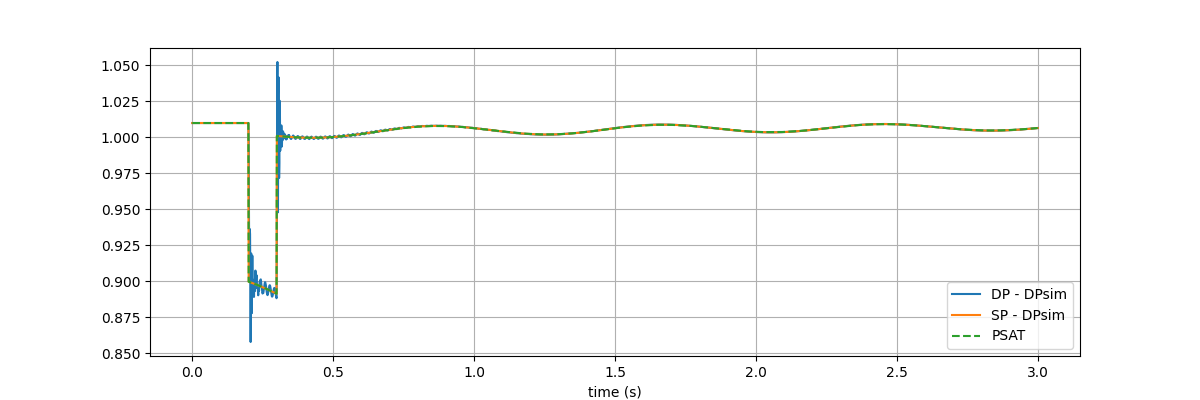

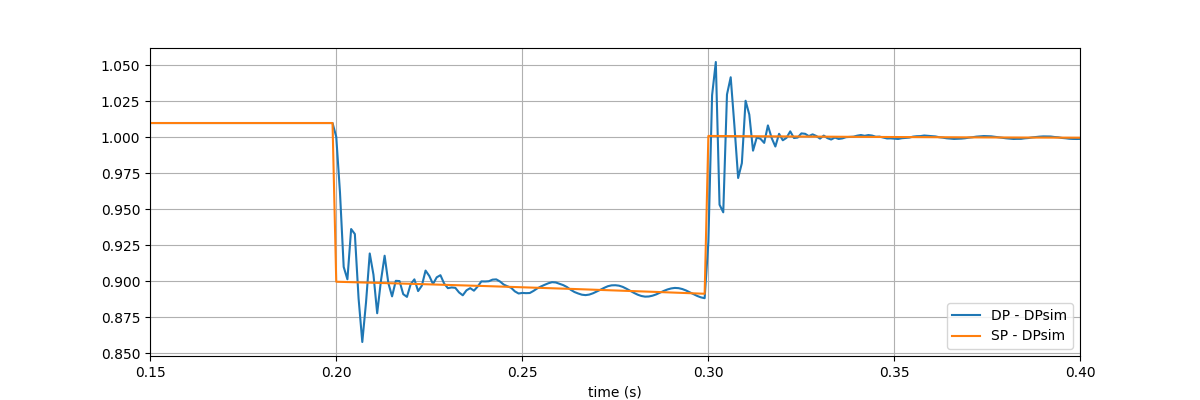

RMSE N3.V  = 0.000060 (pu), which is 0.006% of the nominal value = 1.000 (pu) 


In [51]:
varname_dpsim = 'N3.V'
varname_psat = 'V_Bus03'
nominal_voltage = 69000
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N3", timestep_common=0.001)

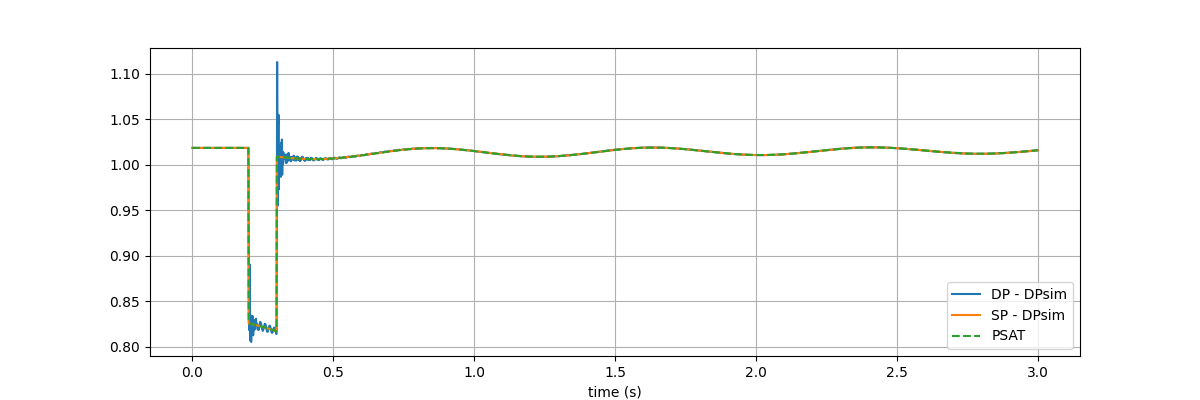

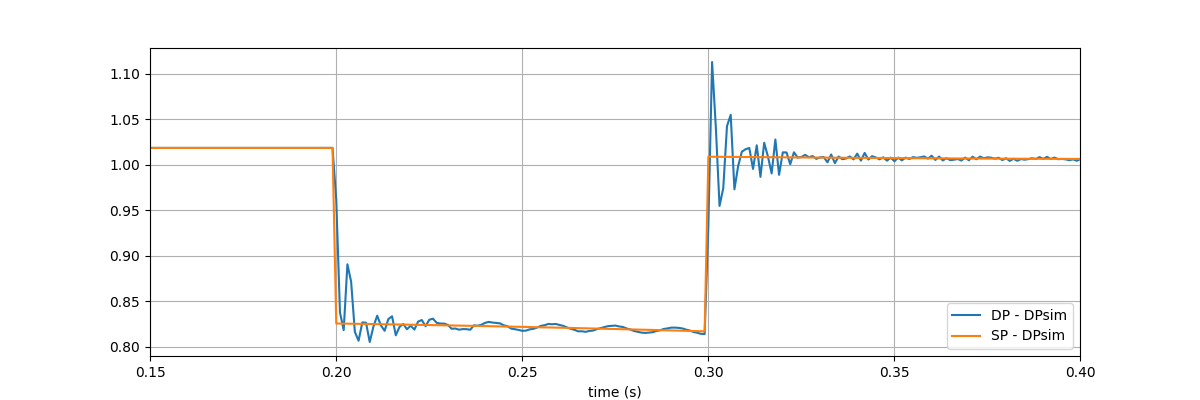

RMSE N4.V  = 0.000056 (pu), which is 0.006% of the nominal value = 1.000 (pu) 


In [52]:
varname_dpsim = 'N4.V'
varname_psat = 'V_Bus04'
nominal_voltage = 69000
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N4", timestep_common=0.001)

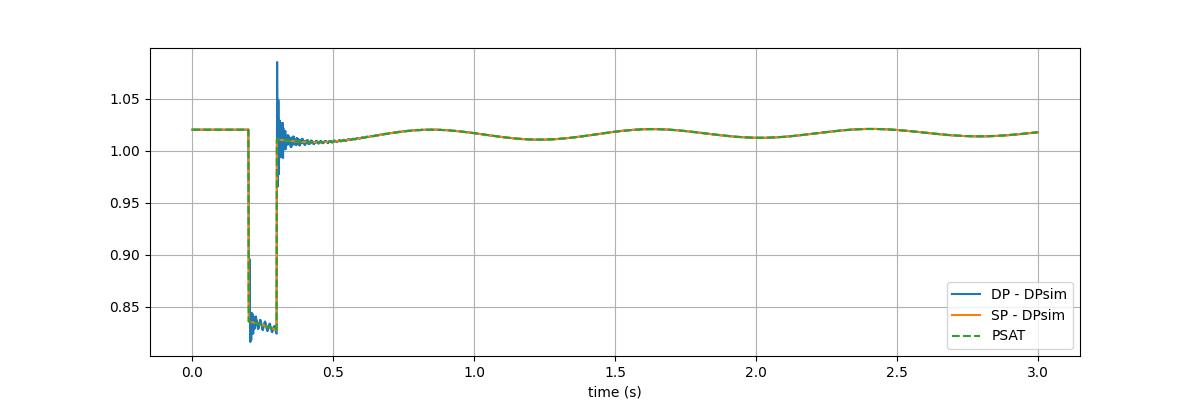

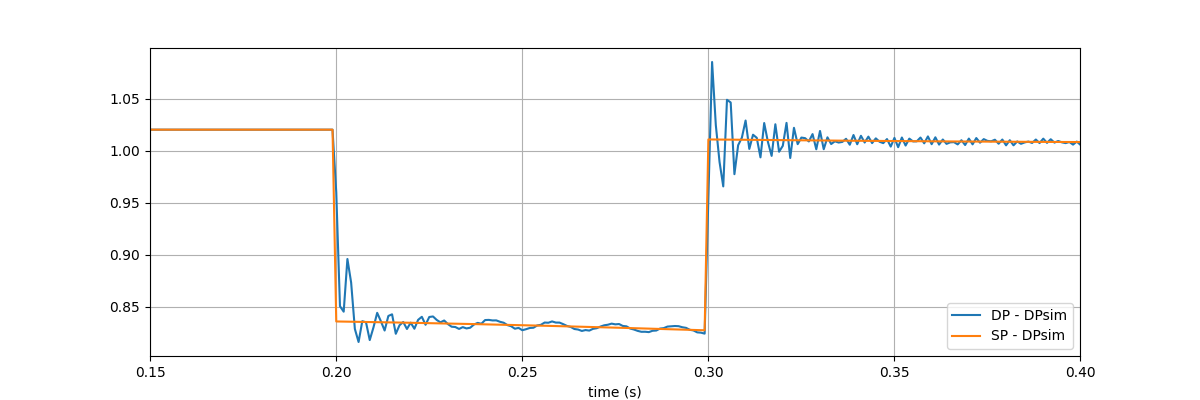

RMSE N5.V  = 0.000055 (pu), which is 0.006% of the nominal value = 1.000 (pu) 


In [53]:
varname_dpsim = 'N5.V'
varname_psat = 'V_Bus05'
nominal_voltage = 69000
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N5", timestep_common=0.001)

#### Low voltage side

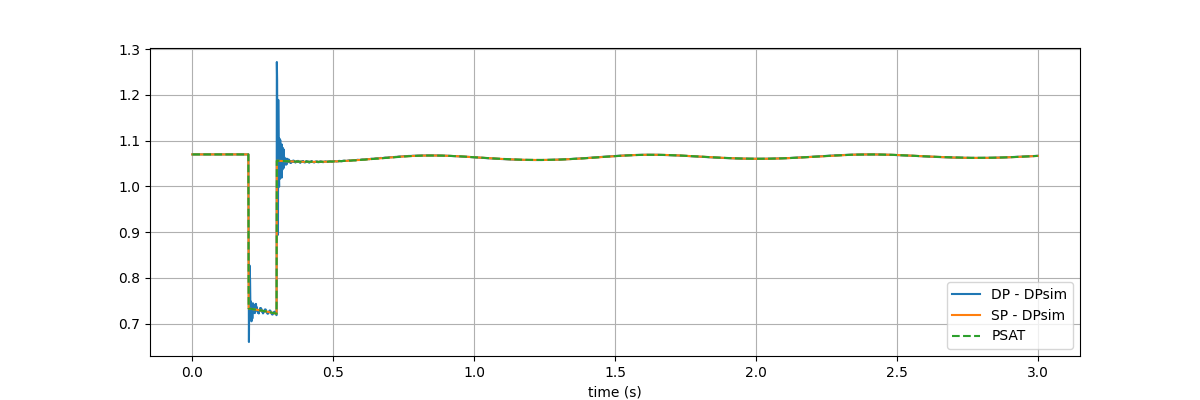

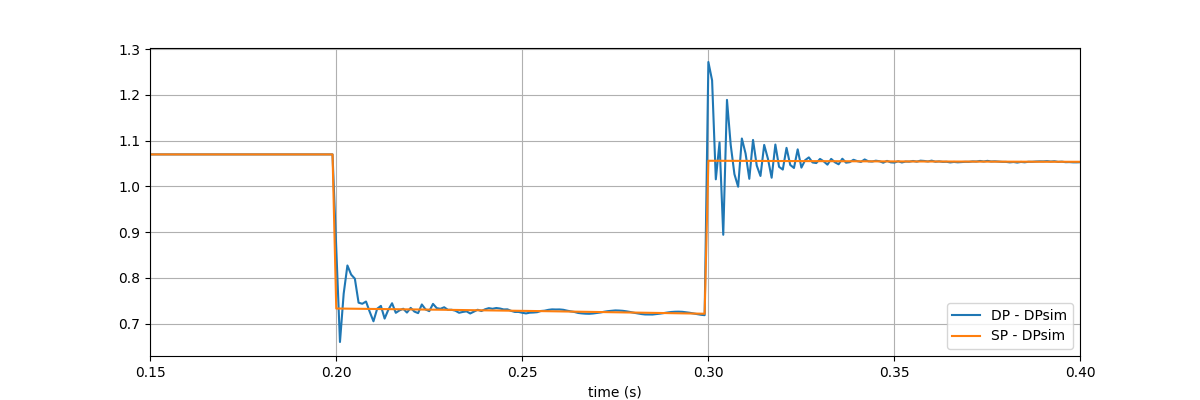

RMSE N6.V  = 0.000057 (pu), which is 0.006% of the nominal value = 1.000 (pu) 


In [54]:
varname_dpsim = 'N6.V'
varname_psat = 'V_Bus06'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N6", timestep_common=0.001)

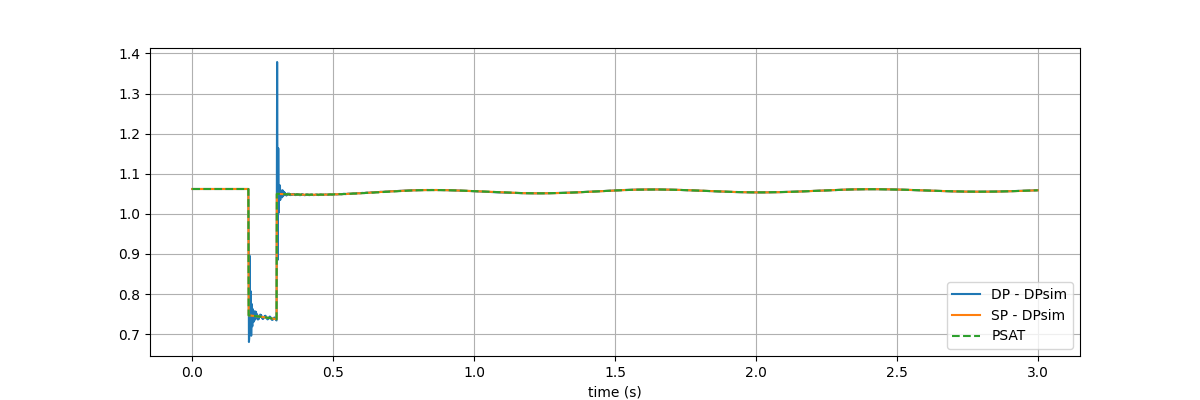

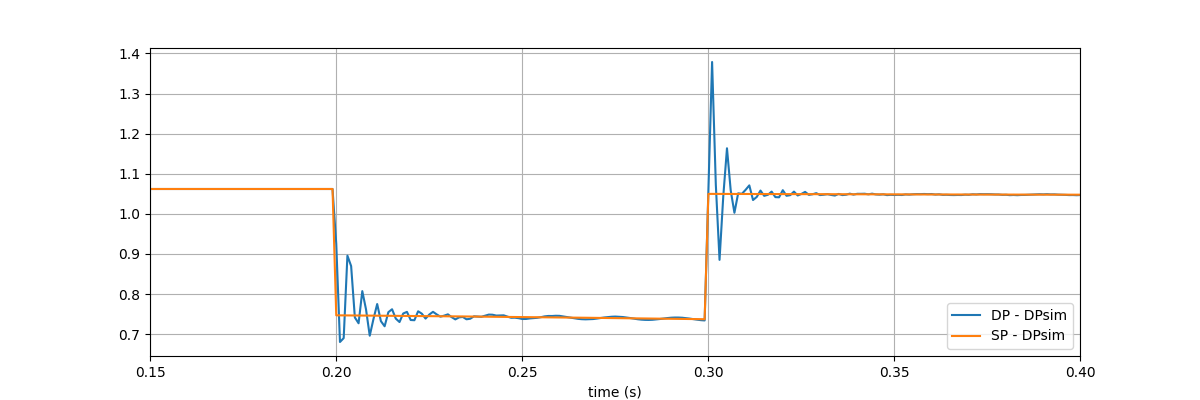

RMSE N7.V  = 0.000051 (pu), which is 0.005% of the nominal value = 1.000 (pu) 


In [55]:
varname_dpsim = 'N7.V'
varname_psat = 'V_Bus07'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N7", timestep_common=0.001)

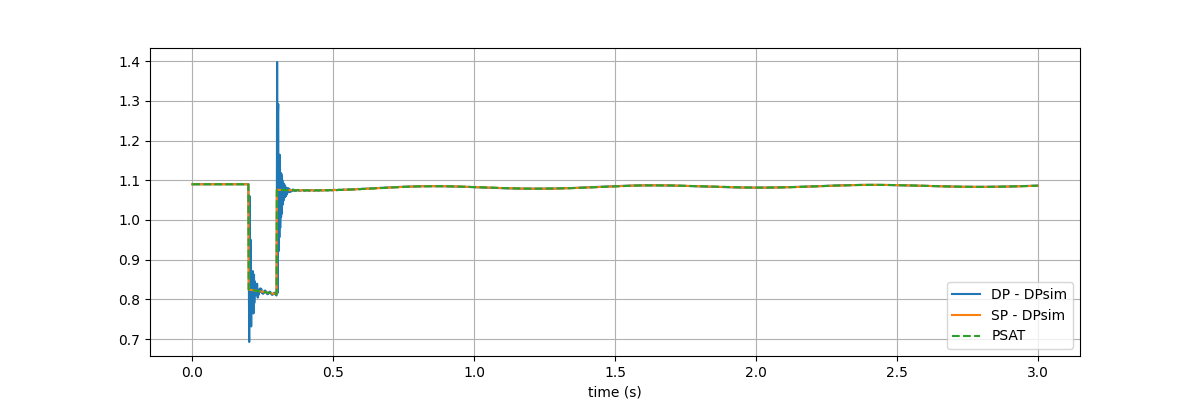

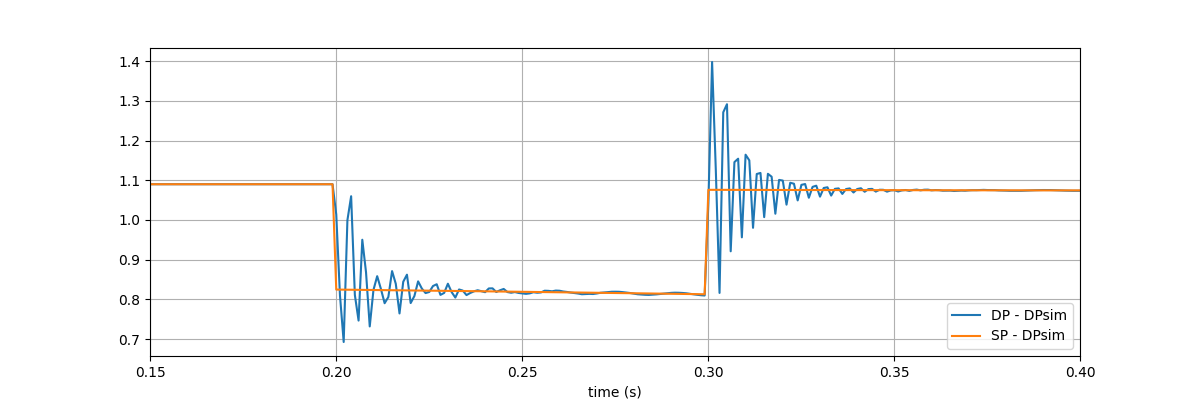

RMSE N8.V  = 0.000045 (pu), which is 0.004% of the nominal value = 1.000 (pu) 


In [56]:
varname_dpsim = 'N8.V'
varname_psat = 'V_Bus08'
nominal_voltage = 18000
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N8", timestep_common=0.001)

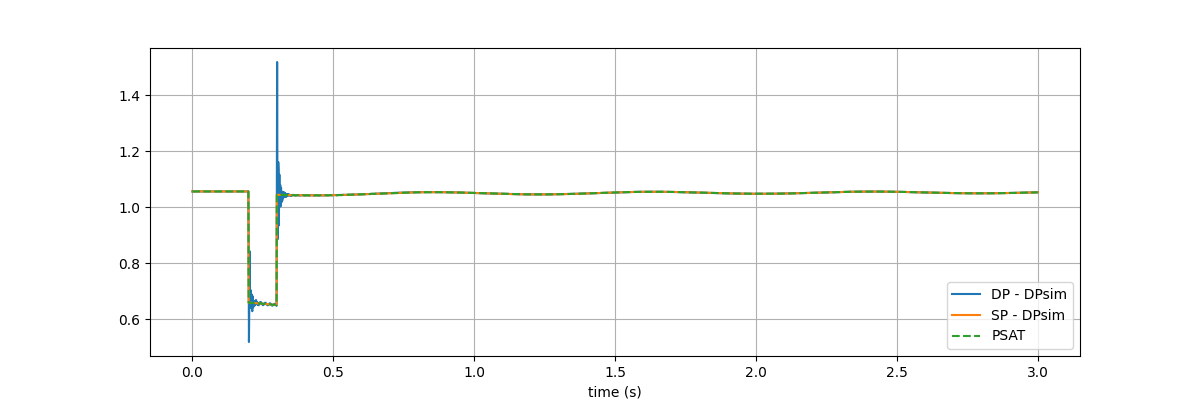

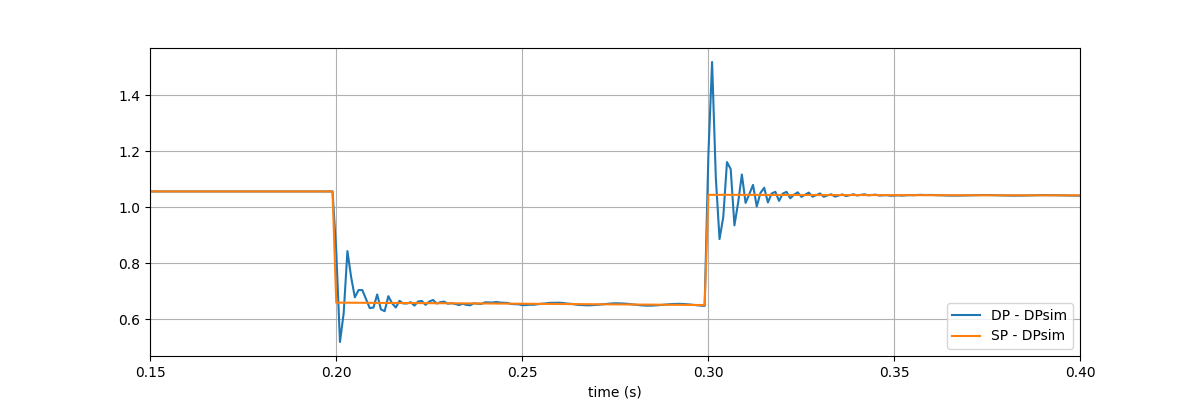

RMSE N9.V  = 0.000051 (pu), which is 0.005% of the nominal value = 1.000 (pu) 


In [57]:
varname_dpsim = 'N9.V'
varname_psat = 'V_Bus09'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N9", timestep_common=0.001)

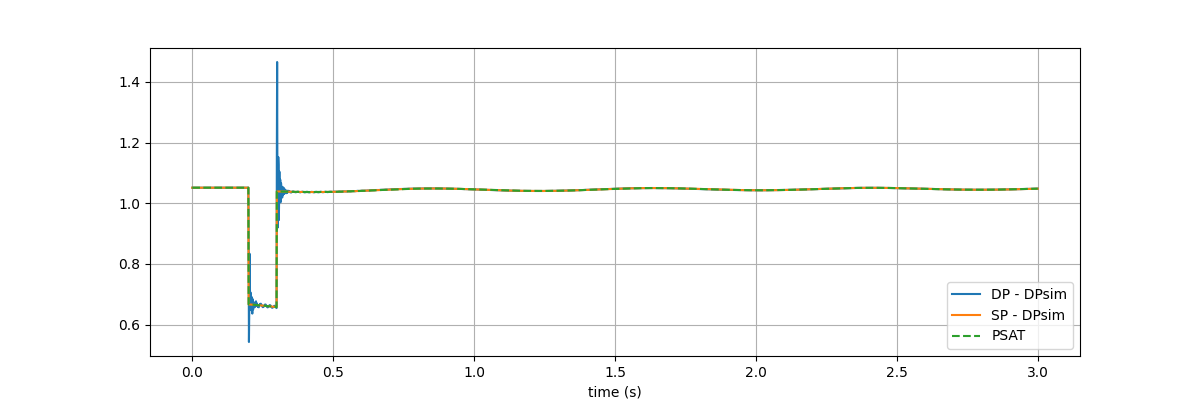

/tmp/ipykernel_1682481/2689009098.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(width, height))


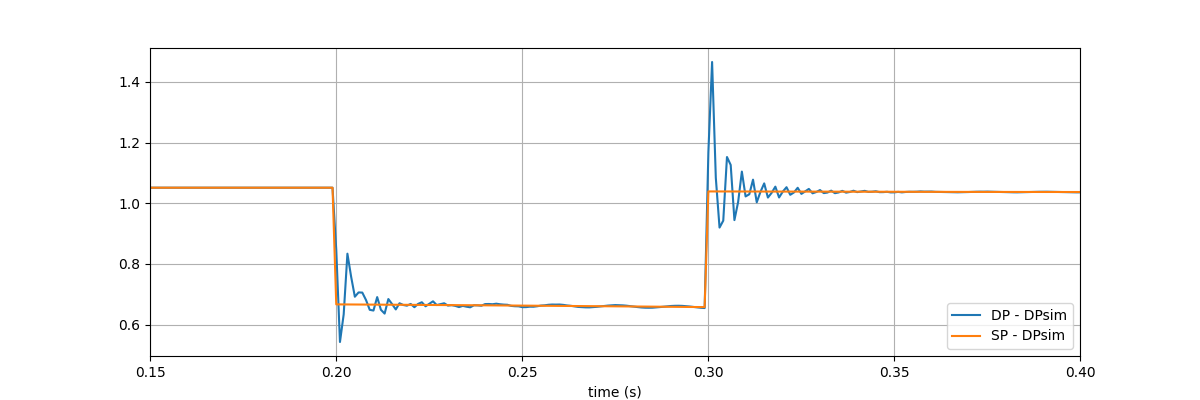

RMSE N10.V  = 0.000052 (pu), which is 0.005% of the nominal value = 1.000 (pu) 


In [58]:
varname_dpsim = 'N10.V'
varname_psat = 'V_Bus10'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N10", timestep_common=0.001)

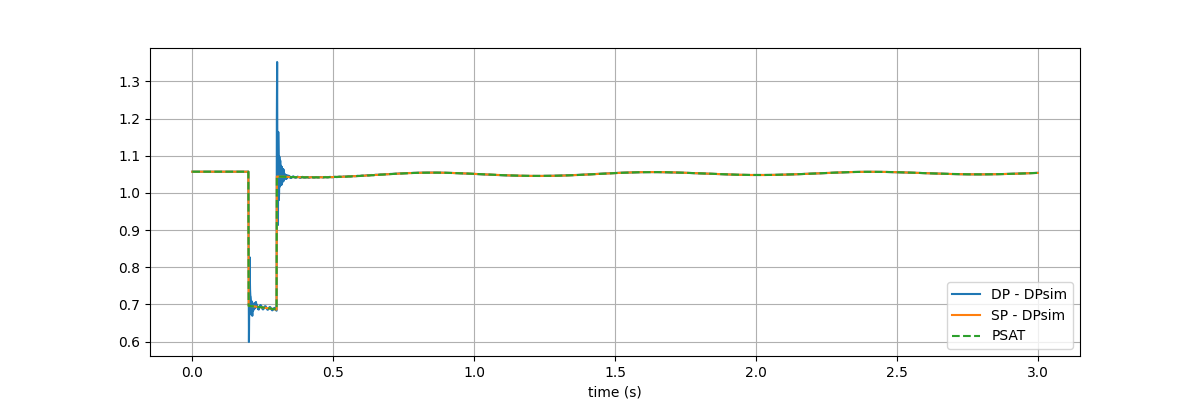

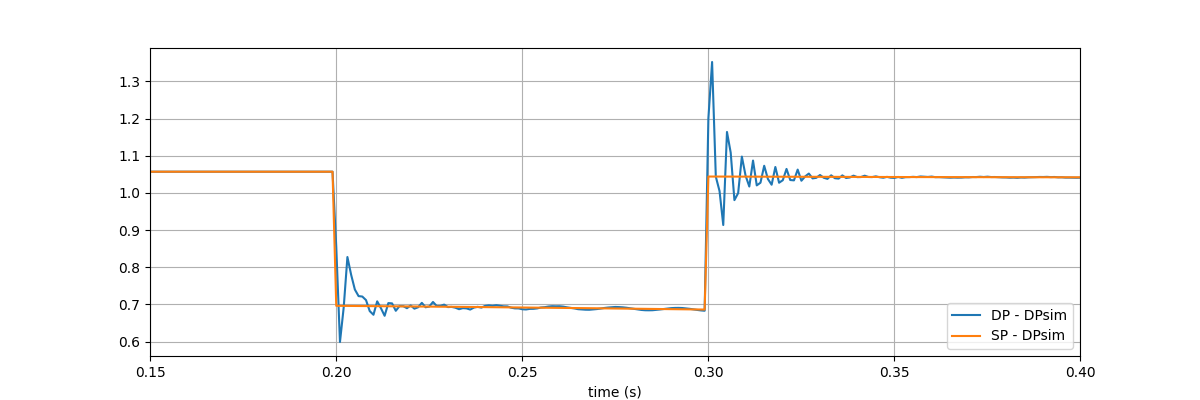

RMSE N11.V  = 0.000054 (pu), which is 0.005% of the nominal value = 1.000 (pu) 


In [59]:
varname_dpsim = 'N11.V'
varname_psat = 'V_Bus11'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N11", timestep_common=0.001)

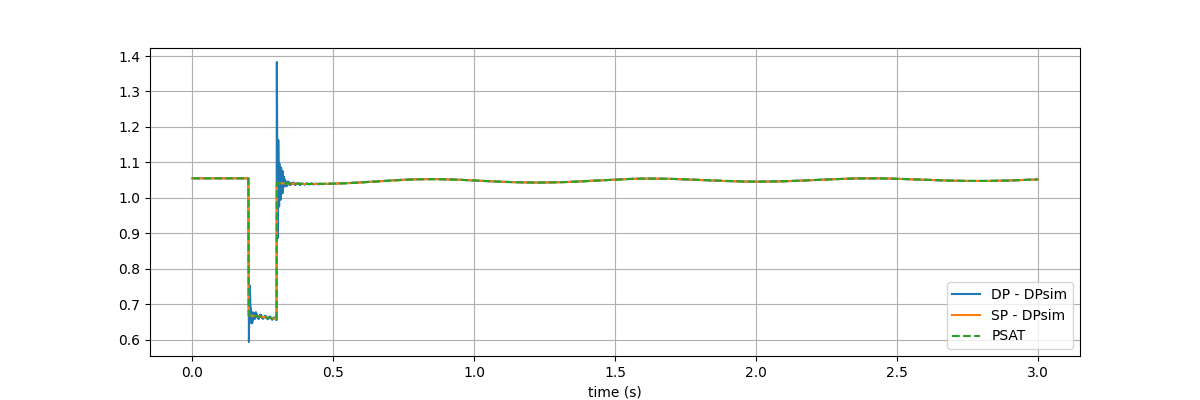

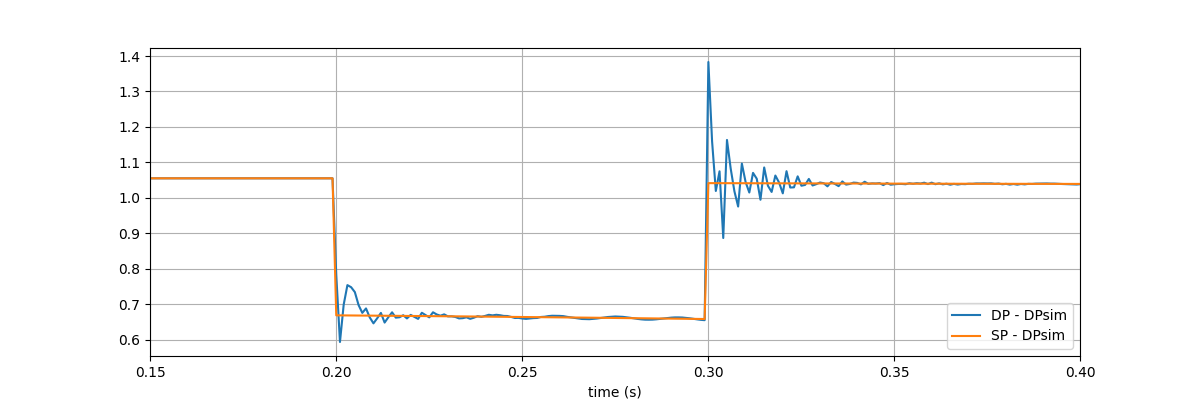

RMSE N12.V  = 0.000056 (pu), which is 0.006% of the nominal value = 1.000 (pu) 


In [60]:
varname_dpsim = 'N12.V'
varname_psat = 'V_Bus12'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N12", timestep_common=0.001)

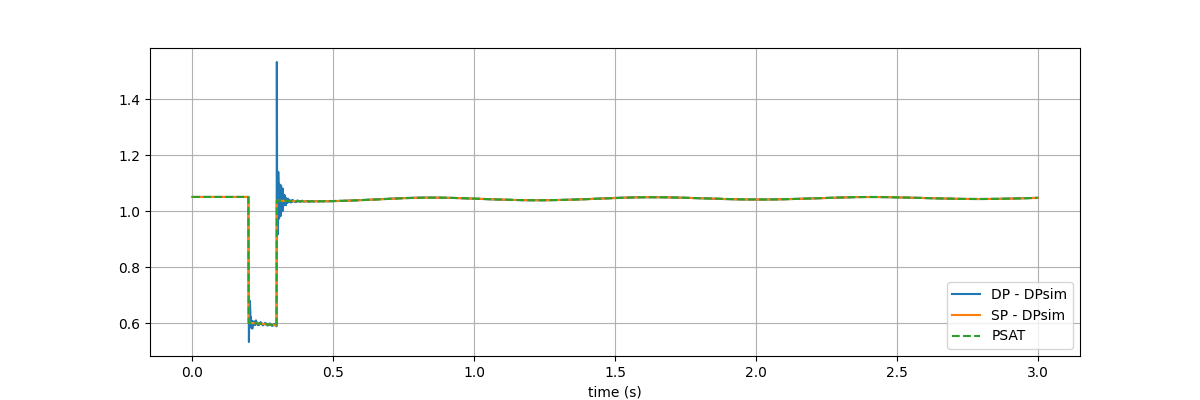

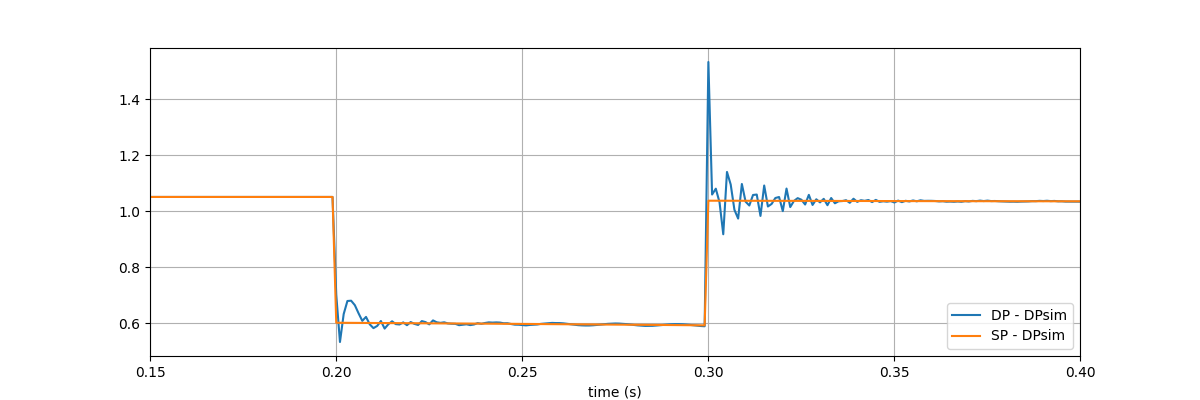

RMSE N13.V  = 0.000055 (pu), which is 0.005% of the nominal value = 1.000 (pu) 


In [61]:
varname_dpsim = 'N13.V'
varname_psat = 'V_Bus13'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N13", timestep_common=0.001)

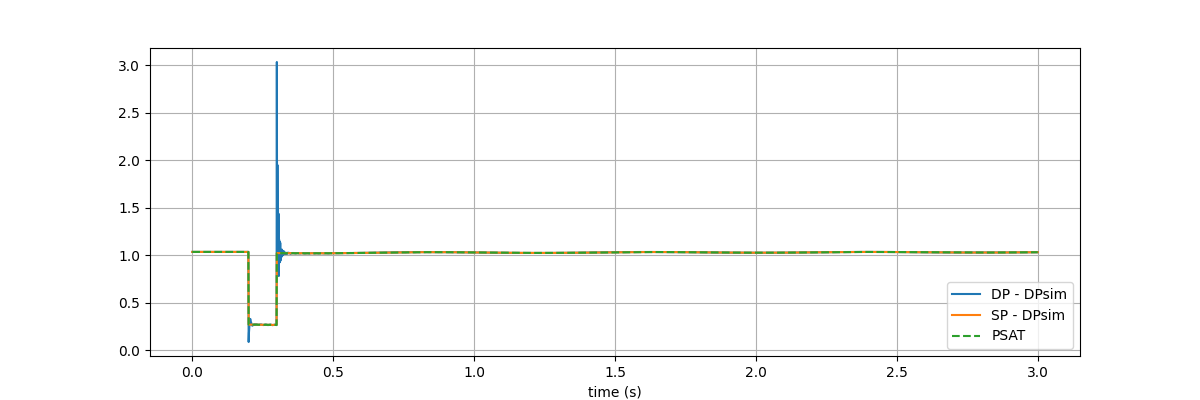

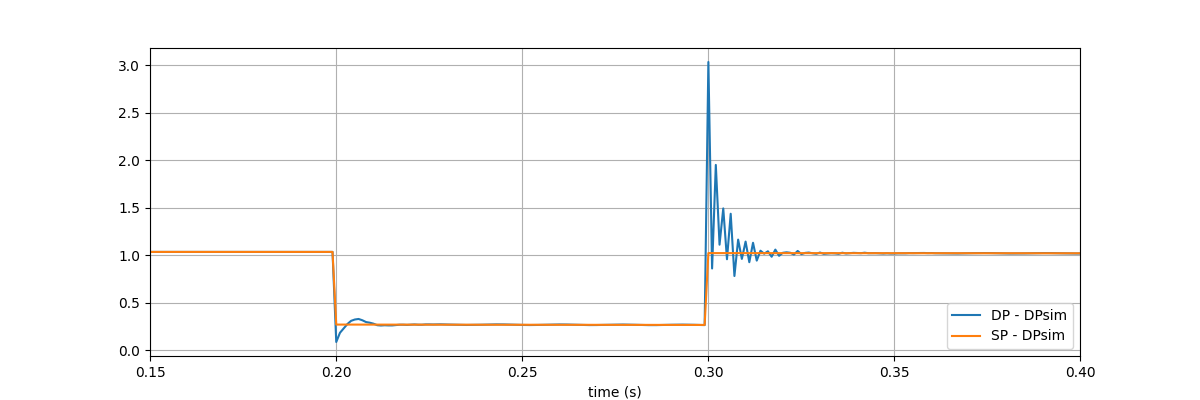

RMSE N14.V  = 0.000051 (pu), which is 0.005% of the nominal value = 1.000 (pu) 


In [62]:
varname_dpsim = 'N14.V'
varname_psat = 'V_Bus14'
nominal_voltage = 13800
plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_sp, ts_dpsim_dp, ts_psat, nominal_voltage, "Voltage magnitude N14", timestep_common=0.001)